In [23]:
import numpy as np
from coupled_LDS import *
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import pymanopt 
import autograd.numpy as anp 
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
import seaborn
seaborn.set_context("talk")
import os

# Standard LDS data generation + testing

In [24]:
S = 200
max_S = 100
T = 100
D = 50
M = 2
max_iter = 100

In [38]:
K1 = 5
K2 = 2

K = K1 + K2
LDS = coupled_LDS.coupled_LDS(D, K1, K2, M)

In [39]:
param = np.load(f'models/K1={K1}_K2={K2}_true_parameters_and_data_low_rank.npz')
u=param['u']
true_x=param['true_x']
true_y=param['true_y']
true_A=param['true_A']
true_B=param['true_B']
true_Q=param['true_Q']
true_mu0=param['true_mu0']
true_Q0=param['true_Q0']
true_C=param['true_C']
true_d=param['true_d']
true_R=param['true_R']

In [40]:
simulation = 0
fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz')
ecll_new=fitted['ecll_new']
ecll_old=fitted['ecll_old']
elbo=fitted['elbo']
ll=fitted['ll']
A=fitted['A']
B=fitted['B']
Q=fitted['Q']
mu0=fitted['mu0']
Q0=fitted['Q0']
C=fitted['C']
d=fitted['d']
R=fitted['R']

FileNotFoundError: [Errno 2] No such file or directory: 'models/K1=5_K2=2_fitted_param_low_rank_simulation=0.npz'

In [41]:
print(np.linalg.eigvals(true_A[:K1,:K1]))
print(np.linalg.eigvals(true_A[K1:,K1:]))
print(np.linalg.eigvals(true_A))

[ 9.25550038e-01  2.03159358e-02  6.73015559e-03 -1.00888678e-18
 -4.81765379e-18]
[0. 0.]
[ 0.00000000e+00  0.00000000e+00  9.25550038e-01  2.03159358e-02
  6.73015559e-03  2.57694522e-18 -3.97495103e-18]


In [29]:
# C PCA
y_flatten = true_y.reshape(true_y.shape[0] * true_y.shape[1], true_y.shape[2]) 
y_mean   = y_flatten.mean(axis=0, keepdims=True)
y_pca    = y_flatten - y_mean
Y_cov = (y_pca.T @ y_pca) / y_pca.shape[0]            
eigvals, eigvecs = np.linalg.eigh(Y_cov)     # ascending order
C_PCA = eigvecs[:, -K:][:, ::-1]
# a, b, c = covariance_alignment(y_flatten, C_PCA, true_C)
# print(a)
# print(b)
# print(c)
# covariance of J in subspace B
# print()
# proj_J_B = C_PCA.T @ C_PCA @ true_C.T
# cov_J_B = proj_J_B @ proj_J_B.T
# print(np.trace(cov_J_B))
# print(np.trace(true_C @ true_C.T))

C_concat = np.concatenate([C_PCA, true_C], axis=1)
print(C_concat.shape)
U, Sval, Vh = np.linalg.svd(C_concat)
print(Sval)

(50, 6)
[1.22497806 1.16348404 1.03997297 0.95836121 0.80393089 0.70670273]


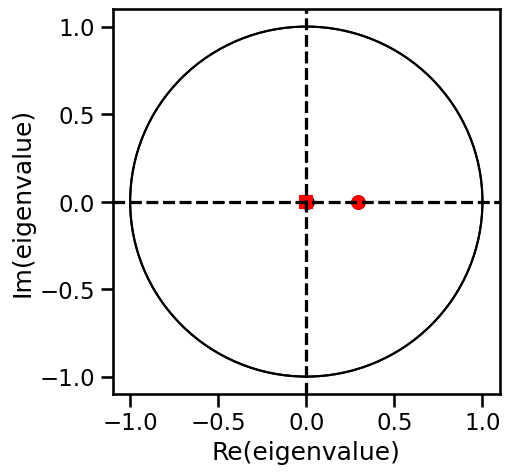

In [30]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

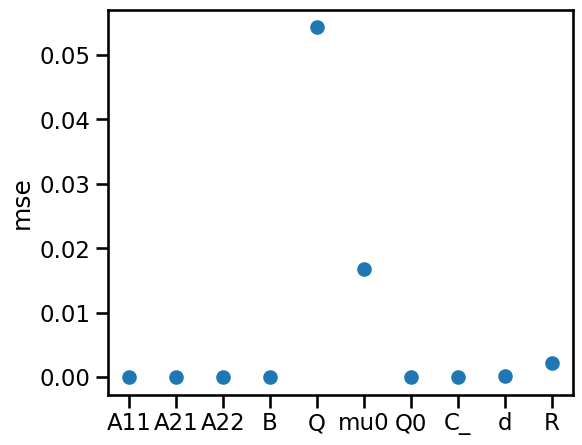

In [20]:
fig, axes = plt.subplots(figsize=(6,5))
plot_mse_parameters(axes, K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

(1,)


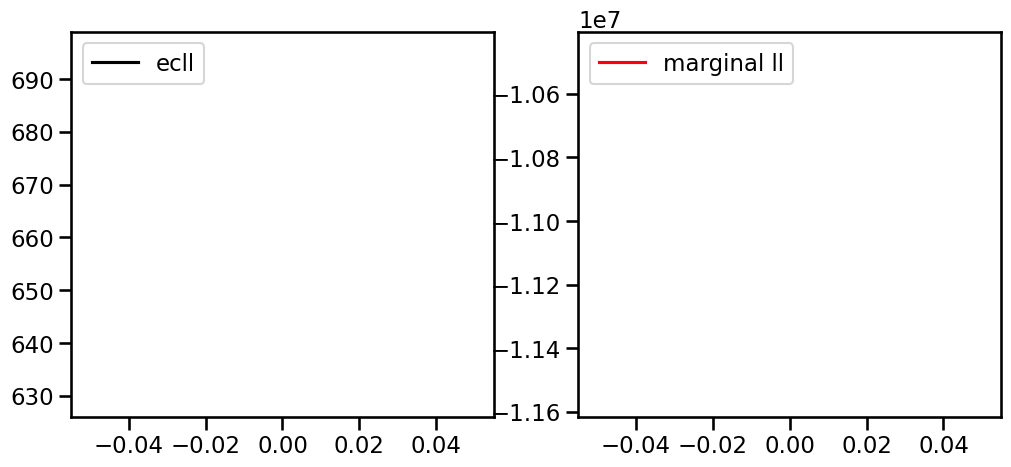

In [21]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
print(elbo.shape)
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll')
axes[1].plot(elbo, color='red', label='marginal ll')
# axes[1].plot(ll.sum(axis=1), color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

In [22]:
ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R, max_iter=max_iter, verbosity=0)

0


KeyboardInterrupt: 

0
(1,)
1
2
(1,)
3
4
5
(1000,)
YES
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_60859/417927197.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/var/folders/w4/p225s7cd19n0j6tss7pdl21w0000gn/T/ipykernel_60859/417927197.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


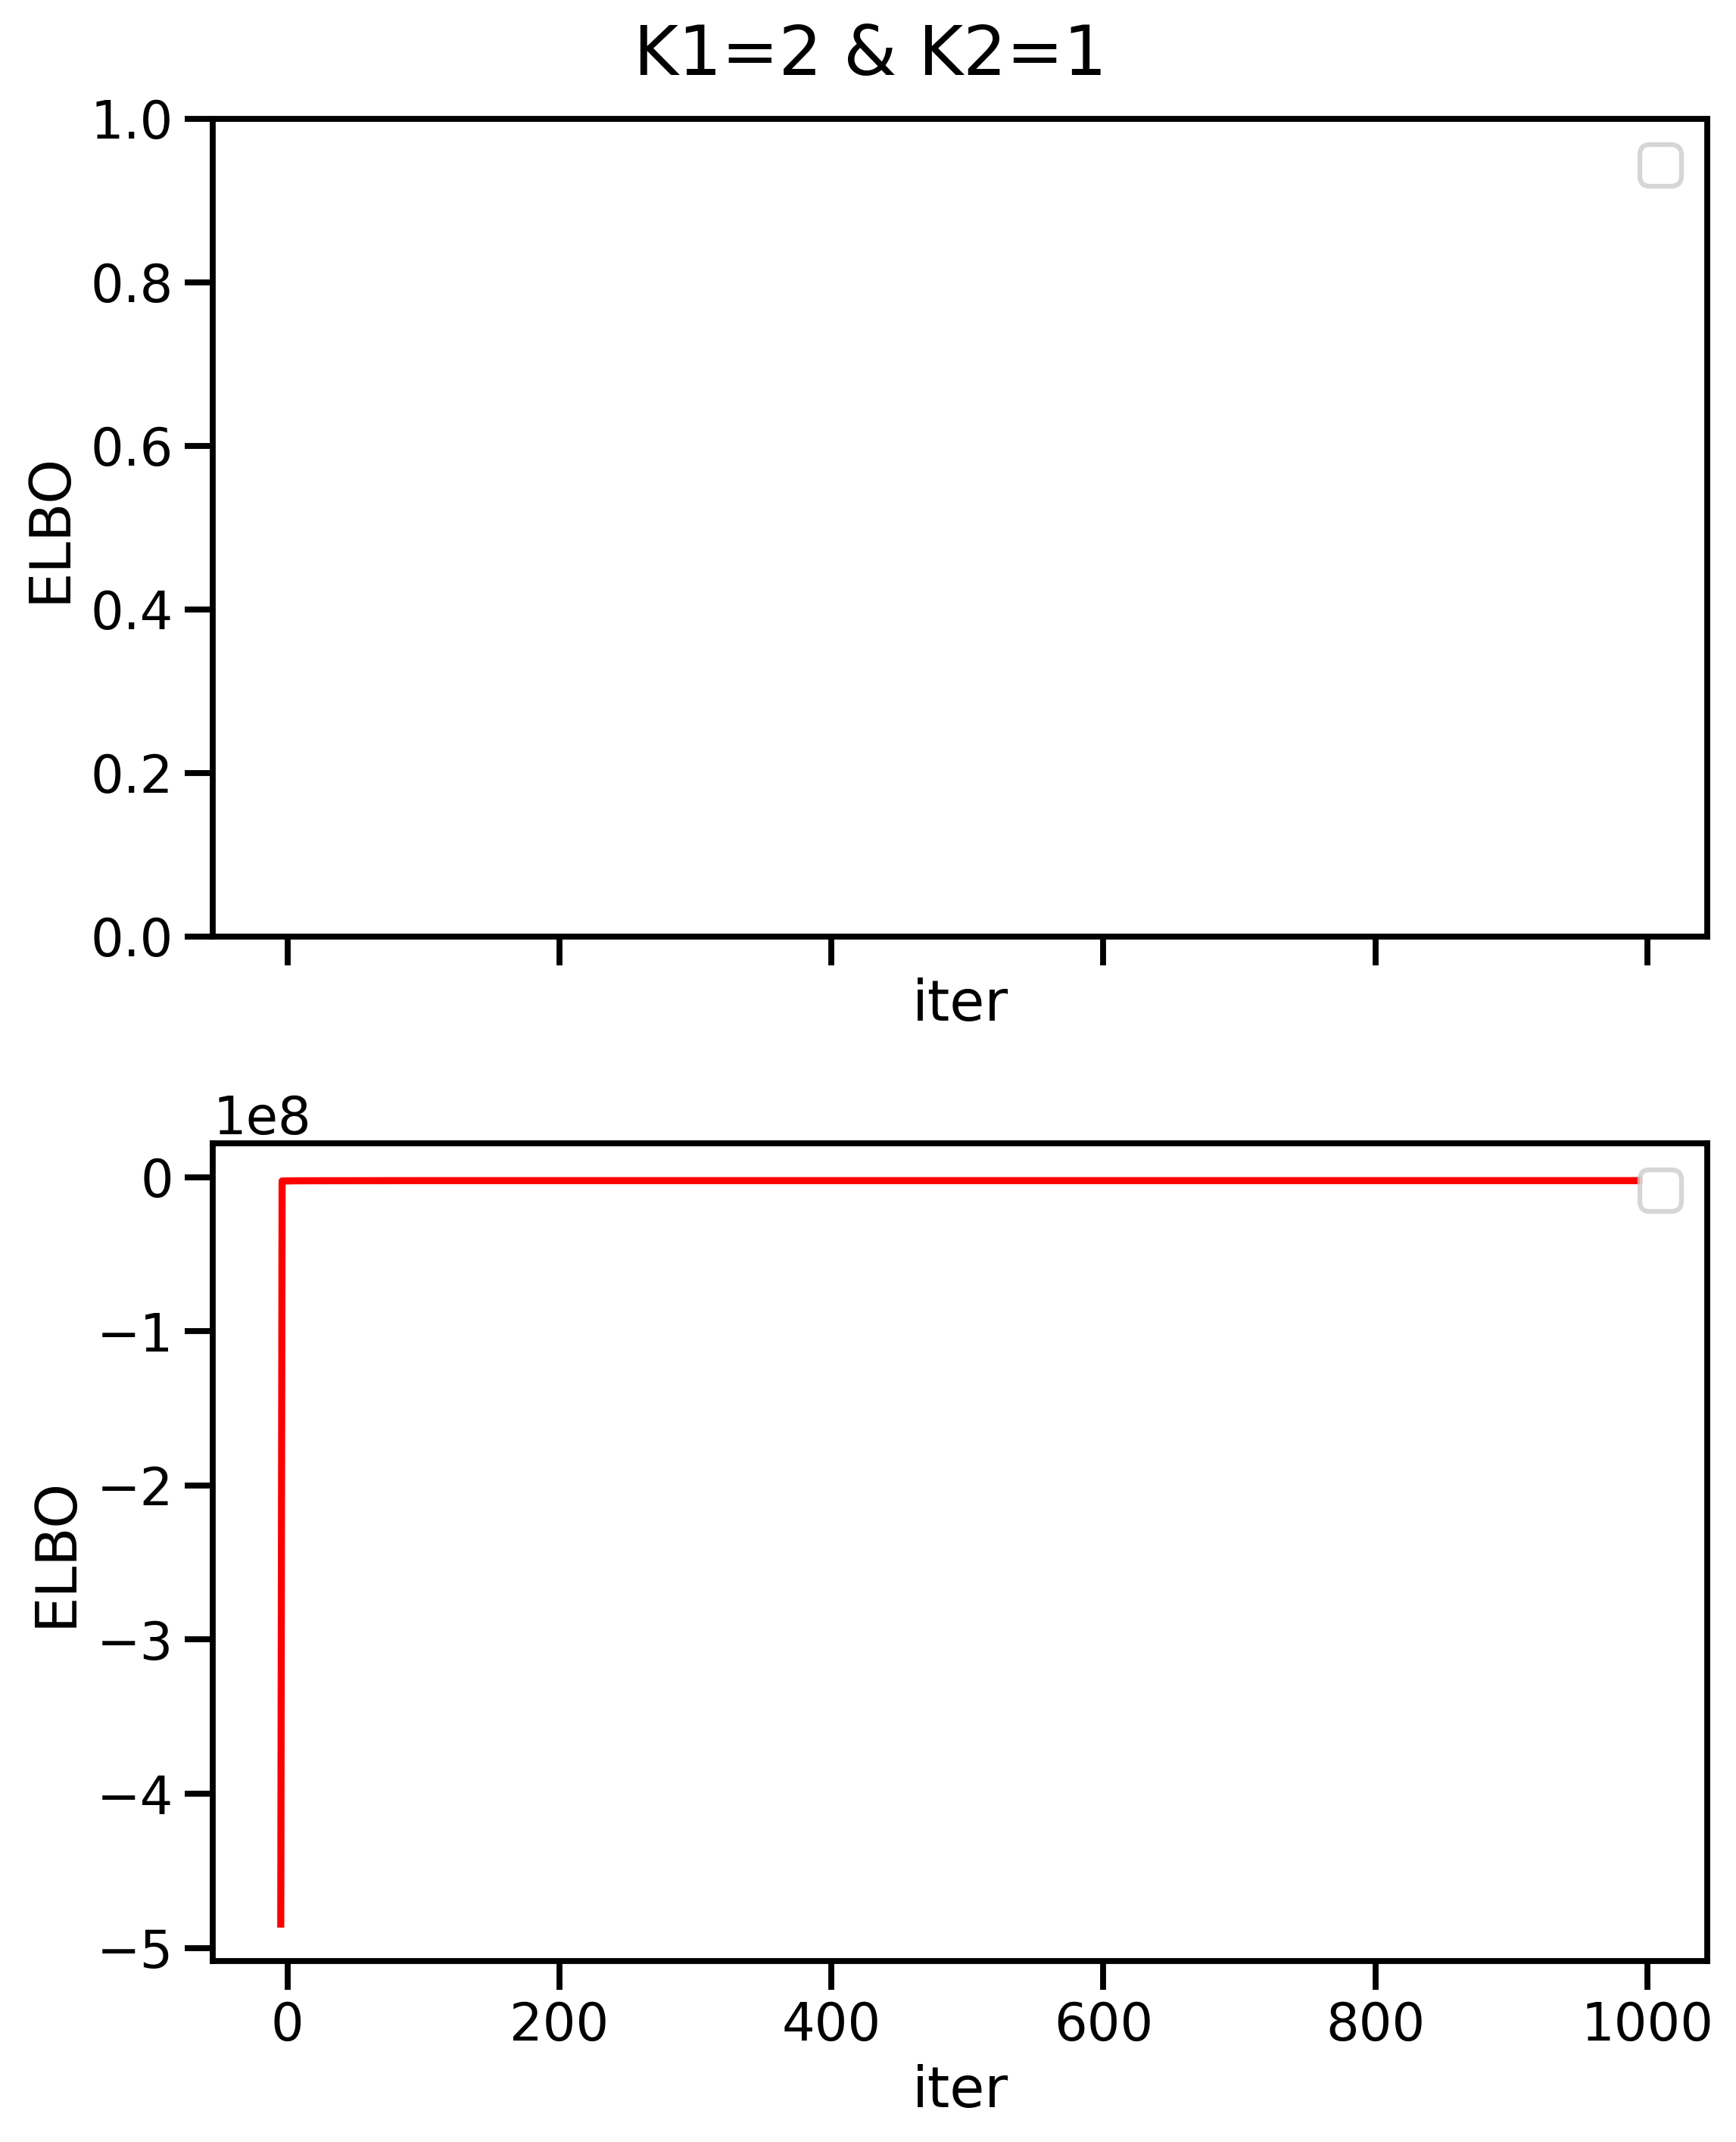

In [37]:
max_iter=1000
eps = 0.1
import mpl_toolkits.axes_grid1.inset_locator as inset
fig, axes = plt.subplots(2,1,figsize=(8,10), dpi=300, sharex=True)
color = ['green','orange','blue'] + ['black' for i in range(27)]
label = ['true','PCA','SSID','best random']

elbos = []

for simulation in range(30):
    print(simulation)
    if os.path.exists(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz'):
        fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_low_rank_simulation={simulation}.npz')
        ecll_new=fitted['ecll_new']
        ecll_old=fitted['ecll_old']
        elbo=fitted['elbo']
        ll = fitted['ll']

        print(elbo.shape)
        if elbo.shape[0] == max_iter:
            if simulation != 0:
                elbos.append(elbo[-1])

            if simulation == 0:
                # max_elbo = elbo[-1]
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
                axes[1].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])

            if simulation in [1,2]:
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
            elif simulation >= 3:
                if 0 < 1: #np.abs((elbo[-1] - max_elbo)) < S * eps:
                    print('YES')
                    axes[1].plot(range(-5,max_iter-5),elbo, color='red')
                else:
                    axes[1].plot(elbo, color='black')


# axes[0].set_yscale('log')
# axes[1].set_yscale('log')
# axes[0].set_ylim(max_elbo*1.07, max_elbo*0.99)
# axes[1].set_ylim(max_elbo*1.07, max_elbo*0.99)
axes[0].set_ylabel('ELBO')
axes[1].set_ylabel('ELBO')
axes[0].set_xlabel('iter')
axes[1].set_xlabel('iter')
axes[0].legend()
axes[1].legend()
fig.suptitle(f'K1={K1} & K2={K2}', y=0.95)
fig.tight_layout()

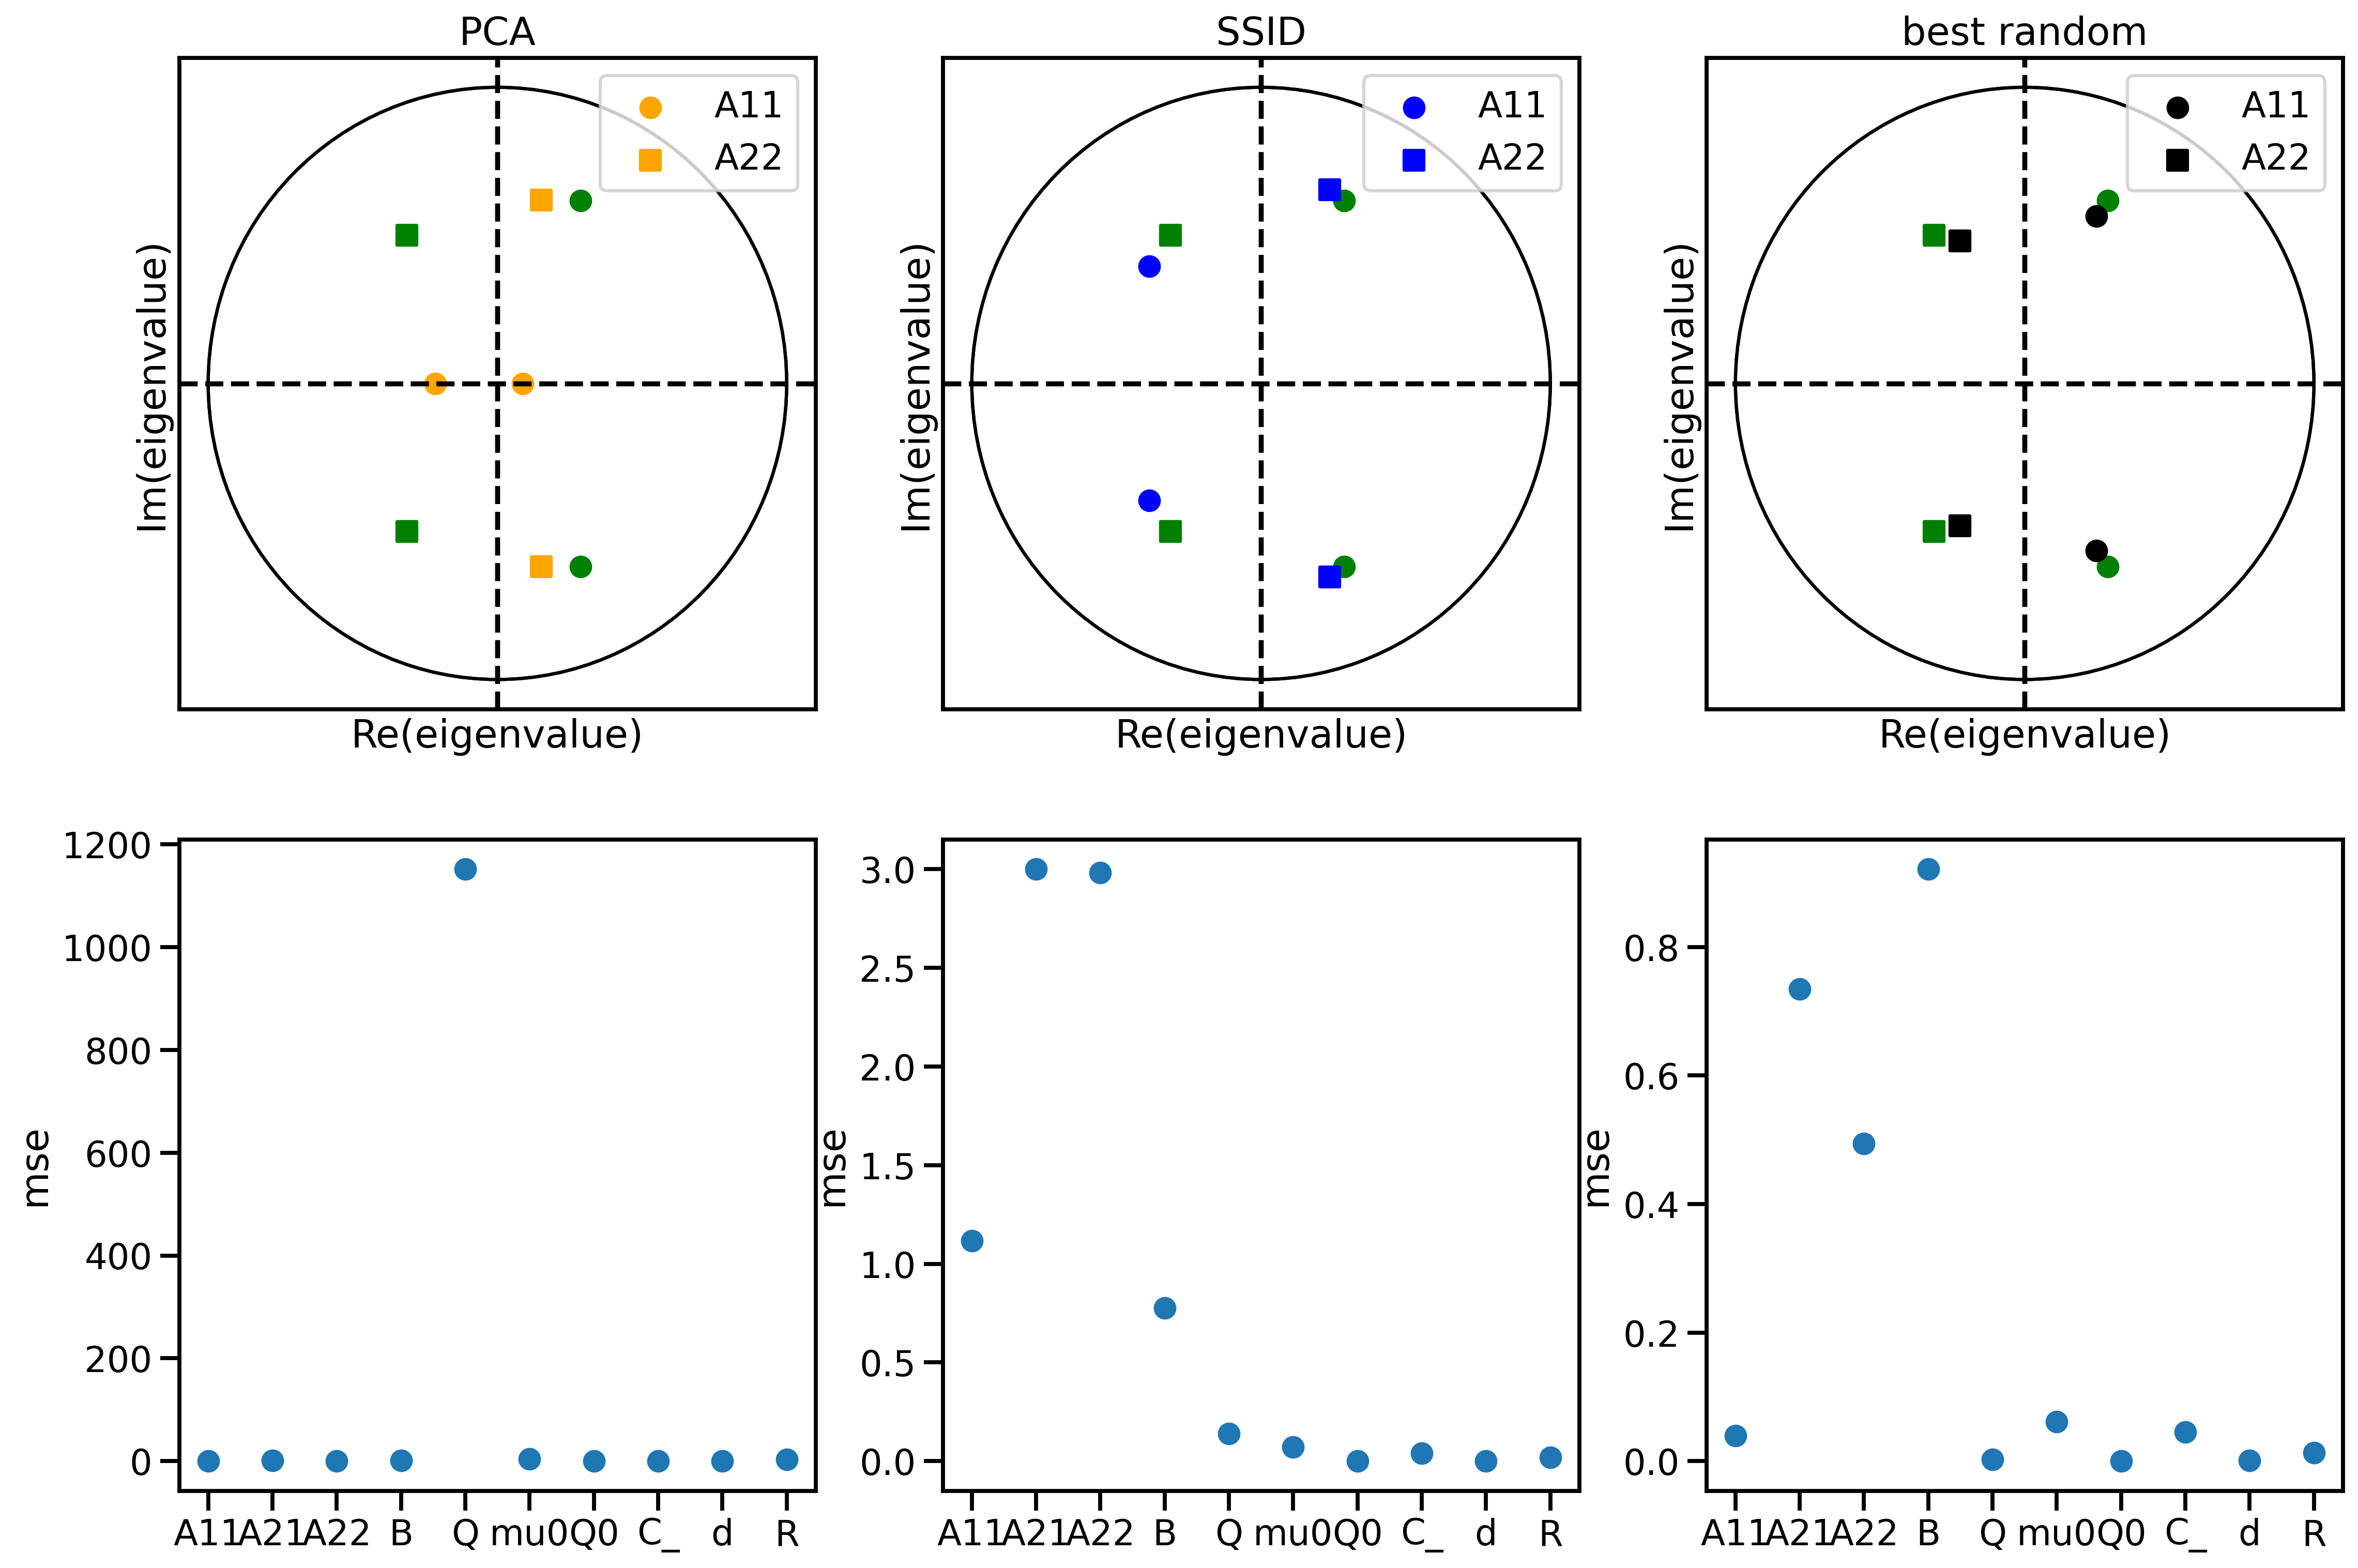

In [61]:
best_ind = np.argmax(elbos)+1


colors = ['green','orange','blue'] + ['black']

fig, axes = plt.subplots(2,3, dpi=300, figsize=(18,12))
ct = 1
for simulation in [1,2,best_ind]:
    fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
    A=fitted['A']
    B=fitted['B']
    Q=fitted['Q']
    mu0=fitted['mu0']
    Q0=fitted['Q0']
    C=fitted['C']
    d=fitted['d']
    R=fitted['R']
    plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='green')
    plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]), color=colors[ct], label=['A11','A22'])
    axes[0,ct-1].set_xticks([])
    axes[0,ct-1].set_yticks([])
    axes[0,ct-1].set_title(label[ct])
    axes[0,ct-1].legend(loc='upper right')
    plot_mse_parameters(axes[1,ct-1], K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

    ct+=1

